In [1]:
import os
import argparse
import time
from glob import glob
import pystac_client
import planetary_computer
import stackstac

import geopandas as gpd
import numpy as np
from copy import copy
import rasterio
from rasterio.merge import merge
from rasterio import mask
from rasterio import plot
import ast
import pandas as pd

In [ ]:
More targeted assessments at known industrial sites
where height estimation is less than 1, we ignore the height,

In [ ]:
# read in data

In [ ]:
python /hpc/home/csr33/ast_object_detection/src/compile_predictions.py --detect_tank_dir "/hpc/group/borsuklab/csr33/object_detection/height_estimation"

In [6]:


#detected_tanks_gdf['class_name'] = detected_tanks_gdf['class_name'].apply(lambda x: ast.literal_eval(x) if "[" in x else x)
#detected_tanks_gdf['confidence'] = detected_tanks_gdf['confidence'].apply(lambda x: ast.literal_eval(x) if "[" in x else x)

for i, row in detected_tanks_gdf.iterrows():
    class_name = row.class_name
    conf = row.confidence
    if isinstance(class_name, list):
        if len(class_name) == 1:
            detected_tanks_gdf.loc[i,"confidence"] = np.mean([float(c) for c in conf])
            detected_tanks_gdf.loc[i,"class_name"] = class_name[0]
        elif len(class_name) == len(conf):
            max_conf_idx = np.argmax(conf)
            max_conf_class = class_name_merge[max_conf_idx]
            detected_tanks_gdf.loc[i,"class_name"] = max_conf_class[0]
            detected_tanks_gdf.loc[i,"confidence"] = np.mean([float(c) for c in conf])
        else:
            print(row.confidence)
            break

In [7]:
#subset based on available data
detected_tanks_gdf = detected_tanks_gdf[detected_tanks_gdf['height'].notnull()]
detected_tanks_gdf_with_capacity = detected_tanks_gdf[~detected_tanks_gdf["capacity"].isnull()] 
detected_tanks_gdf_with_capacity = detected_tanks_gdf_with_capacity[detected_tanks_gdf_with_capacity["diameter"]>0]

detected_tanks_gdf_with_capacity_height_subset = detected_tanks_gdf_with_capacity[(detected_tanks_gdf_with_capacity["height"]<30) & \
                                                (detected_tanks_gdf_with_capacity["height"]>2)]

detected_tanks_gdf_with_capacity_height_subset.to_parquet("/hpc/group/borsuklab/csr33/object_detection/detected_tanks_gdf_with_capacity_height_subset.parquet")
detected_tanks_gdf_with_capacity_height_subset[["height", "diameter", "capacity", "specific_gravity","geometry"]].to_file("/hpc/group/borsuklab/csr33/object_detection/detected_tanks_gdf_with_capacity_height_subset.geojson", driver='GeoJSON')

(0.0, 100.0)

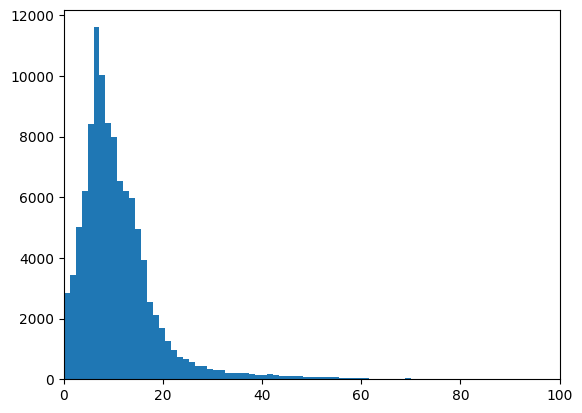

In [55]:
import matplotlib.pyplot as plt
plt.hist(detected_tanks_gdf_with_capacity["height"], bins=1000)
plt.xlim([0,100])

In [10]:
crs = "EPSG:4326"


In [11]:
slosh_boundary_dir = "/datacommons/borsuklab-ast-archive/nat_hazard_data/slosh/unzip/v3_extent_shp"
cat1_slosh_boundary = gpd.read_file(os.path.join(slosh_boundary_dir, "cat1_merge_Dissolve.shp")).to_crs(crs)

In [77]:
#detected_tanks_gdf_with_capacity_height_subset.sort_values("capacity", ascending=False)

In [7]:
rewrite to do capacity for complete predicted data?
where did specific gravity go?

,confidence,class_name,bbox_pixel_coords,tile_names,utm_coords,diameter,utm_proj,geometry,height,chemical_name,cas_number,facility_name
319,"[0.9214309453964233, 0.6490179896354675]",['closed_roof_tank'],"[11499, 14465, 11661, 14621]",m_3009122_ne_15_030_20211116,"[664775.85, 3399064.35, 664824.4500000001, 339...",46.8,EPSG:26915,"POLYGON ((-91.27874 30.71304, -91.27874 30.712...",16.500000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
249,"[0.9202601313591003, 0.778704822063446]",['closed_roof_tank'],"[13418, 16036, 13550, 16152]",m_3009122_ne_15_030_20211116,"[665351.55, 3398593.0500000003, 665391.15, 339...",34.8,EPSG:26915,"POLYGON ((-91.27290 30.70871, -91.27290 30.708...",15.720000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
250,"[0.914099931716919, 0.9086913466453552]",['closed_roof_tank'],"[13439, 16534, 13620, 16743]",m_3009122_ne_15_030_20211116,"[665357.85, 3398443.65, 665412.15, 3398380.95]",54.3,EPSG:26915,"POLYGON ((-91.27271 30.70736, -91.27271 30.706...",14.760000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
251,"[0.9115021228790283, 0.8991819620132446]",['closed_roof_tank'],"[13347, 16234, 13572, 16442]",m_3009122_ne_15_030_20211116,"[665330.25, 3398533.65, 665397.75, 3398471.25]",62.4,EPSG:26915,"POLYGON ((-91.27285 30.70817, -91.27285 30.707...",14.760000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
273,"[0.910485029220581, 0.8887038230895996]",['closed_roof_tank'],"[12302, 13366, 12429, 13482]",m_3009122_ne_15_030_20211116,"[665016.75, 3399394.0500000003, 665054.85, 339...",34.8,EPSG:26915,"POLYGON ((-91.27628 30.71598, -91.27628 30.715...",15.690000,"['Hydrogen sulfide', 'Ethylbenzene', 'Toluene'...","['7783-06-4', '100-41-4', '108-88-3', '1330-20...",[PORT HUDSON TERMINAL]
...,...,...,...,...,...,...,...,...,...,...,...,...
637,0.5014625191688538,closed_roof_tank,"[8686, 22518, 8693, 22525]",m_3109062_sw_15_030_20211120,"[752780.8500000001, 3433233.75, 752782.9500000...",2.1,EPSG:26915,"POLYGON ((-90.35241 31.00561, -90.35241 31.005...",NaN,None,None,None
993,0.5012210607528687,closed_roof_tank,"[8186, 485, 8194, 493]",m_3308062_nw_17_060_20210426,"[563013.9, 3665264.7, 563018.7000000001, 36652...",4.8,EPSG:26917,"POLYGON ((-80.32445 33.12425, -80.32445 33.124...",NaN,None,None,None
854,0.501176118850708,closed_roof_tank,"[271, 24061, 283, 24071]",m_3009034_ne_15_030_20211120,"[709821.4500000001, 3369329.5500000003, 709825...",3.0,EPSG:26915,"POLYGON ((-90.81507 30.43783, -90.81507 30.437...",18.610001,None,None,None
390,0.5011230707168579,closed_roof_tank,"[4551, 5386, 4559, 5394]",m_2608040_sw_17_060_20191120_20200113,"[589770.9, 2921444.1, 589775.7000000001, 29214...",4.8,EPSG:26917,"POLYGON ((-80.09981 26.41036, -80.09981 26.410...",NaN,['Zinc compounds'],['N982'],[NHS U.S. LLC]


In [ ]:
detected_tanks = gpd.read_file("/hpc/group/borsuklab/csr33/object_detection/detected_tanks_slosh_data_added.geojson")
original_ast_dataset = gpd.read_file("/datacommons/borsuklab-ast-archive/ast/tile_level_annotation_multiple_capture_date_neighbor_tile_removed/tile_level_annotation_multiple_capture_date_neighbor_tile_removed.geojson")
cat1_slosh_boundary = gpd.read_file(os.path.join(slosh_boundary_dir, "cat1_merge_Dissolve.shp")).to_crs(crs)
#detected_tanks_in_slosh = gpd.clip(detected_tanks, cat1_slosh_boundary)
annotated_tanks_in_slosh = gpd.clip(original_ast_dataset, cat1_slosh_boundary)

In [ ]:
annotated_tanks_in_slosh

In [ ]:
detected_tanks_in_slosh